In [84]:
import sys
sys.path.insert(0, "../..")

import jax
import jax.numpy as jnp

import jax.scipy
import jax.scipy.special

from tqdm import tqdm
from functools import partial

import module.samplers
import module.hamiltonians
import module.wavefunctions
import module.misc.cutoffs as cutoffs

import flax.linen as nn

import optax
import numpy as np
from matplotlib import pyplot as plt

import netket.nn.activation
import pickle

In [85]:
key = jax.random.PRNGKey(0)

In [86]:
def getLine(phi, theta, r_max = 10, N = 2000):
    r = jnp.linspace(-r_max, r_max, num = N)
    x = jnp.cos(phi)*jnp.sin(theta) * r
    y = jnp.sin(phi)*jnp.sin(theta) * r
    z = jnp.cos(theta) * r

    return r, jnp.stack((x,y,z), axis = 1)

## Potential Energy

In [87]:
dist = 2.003030303030303
E_f = -1.136472793542

R = jnp.array([[dist/2,0,0],[-dist/2,0,0]])     # nuclei positions
k = jnp.array([1.,1.])                          # potential energy coefficients (nuclear charge)

In [88]:
def calc_E_nuc():
    acc = 0
    for i in range(len(R)):
        for j in range(i + 1, len(R)):
            d = jnp.sqrt(jnp.sum((R[i] - R[j])**2))
            acc += k[i] * k[j] / d

    return acc

E_nuc = calc_E_nuc()

In [142]:
#
# The potential energy function depending on the coordinates
#
def potential(x, params):
    x1_ = x[:, 0:3]
    x2_ = x[:, 3:6]

    x1 = jnp.expand_dims(x1_, axis = 1)
    r1 = jnp.expand_dims(R,  axis = 0)
    d1 = jnp.sqrt(jnp.sum((x1 - r1)**2, axis = 2))

    x2 = jnp.expand_dims(x2_, axis = 1)
    r2 = jnp.expand_dims(R,  axis = 0)
    d2 = jnp.sqrt(jnp.sum((x2 - r2)**2, axis = 2))

    dee = jnp.sqrt(jnp.sum((x1_-x2_)**2, axis = 1))

    p = -jnp.sum(k/d1, axis = 1) - jnp.sum(k/d2, axis = 1) + 1/dee + E_nuc
    return p


# the hamiltonian
hamiltonian = module.hamiltonians.Particles(masses = [1.,1.], potential = potential)

## Construct Neural Network

In [143]:
def act(x):
    return nn.softplus(x)

In [144]:
class NN(nn.Module):
    """
    Constructs a neural network.

    possible activation functions:
    netket.nn.activation.log_cosh(x)
    nn.softplus()
    """
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(40, name="dense2", param_dtype="float64", bias_init=jax.random.normal)(x)
        x = act(x)
        x = nn.Dense(40, name="dense3", param_dtype="float64", bias_init=jax.random.normal)(x)
        x = act(x)
        x = nn.Dense(25, name="dense4", param_dtype="float64", bias_init=jax.random.normal)(x)
        x = act(x)
        x = nn.Dense(1, name="dense5", param_dtype="float64", bias_init=jax.random.normal)(x)
        return jnp.squeeze(x)

## Construct Ansatz

In [145]:
class Ansatz(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__(input_shape = (6,))

        self.nn = NN()


    def init_param(self, key):
        a = jax.random.normal(key)**2
        key, key2 = jax.random.split(key)
        b = jax.random.normal(key)**2

        nn_param = self.nn.init(key2, jnp.empty((4,)))

        return {"alpha": a, "beta": b, "nn":nn_param}
    
    def eval_nn(self, parameters, x):
        x1_ = x[:, 0:3]
        x2_ = x[:, 3:6]

        r1A = jnp.sqrt((x1_[:, 0] - dist/2)**2 + x1_[:, 1]**2 + x1_[:, 2]**2 + 0.1)
        r1B = jnp.sqrt((x1_[:, 0] + dist/2)**2 + x1_[:, 1]**2 + x1_[:, 2]**2 + 0.1)

        r2A = jnp.sqrt((x2_[:, 0] - dist/2)**2 + x2_[:, 1]**2 + x2_[:, 2]**2 + 0.1)
        r2B = jnp.sqrt((x2_[:, 0] + dist/2)**2 + x2_[:, 1]**2 + x2_[:, 2]**2 + 0.1)

        coord = jnp.stack((r1A, r1B, r2A, r2B), axis = 1)
        coord2 = jnp.stack((r2A, r2B, r1A, r1B), axis = 1)

        return self.nn.apply(parameters["nn"], coord) + self.nn.apply(parameters["nn"], coord2)

    
    def calc_logpsi(self, parameters, x):
        x1_ = x[:, 0:3]
        x2_ = x[:, 3:6]

        r1A = jnp.sqrt((x1_[:, 0] - dist/2)**2 + x1_[:, 1]**2 + x1_[:, 2]**2 + 0.1)
        r1B = jnp.sqrt((x1_[:, 0] + dist/2)**2 + x1_[:, 1]**2 + x1_[:, 2]**2 + 0.1)

        r2A = jnp.sqrt((x2_[:, 0] - dist/2)**2 + x2_[:, 1]**2 + x2_[:, 2]**2 + 0.1)
        r2B = jnp.sqrt((x2_[:, 0] + dist/2)**2 + x2_[:, 1]**2 + x2_[:, 2]**2 + 0.1)

        lambd1 = r1A + r1B
        mu1 = r1A - r1B

        lambd2 = r2A + r2B
        mu2 = r2A - r2B

        psi1 = jnp.exp(-0.5*dist*parameters["alpha"]*lambd1)*jnp.cosh(0.5*dist*parameters["beta"]*mu1)
        psi2 = jnp.exp(-0.5*dist*parameters["alpha"]*lambd2)*jnp.cosh(0.5*dist*parameters["beta"]*mu2)

        # nn_out = self.eval_nn(parameters, x)

        return jnp.log(psi1) + jnp.log(psi2)

In [146]:
ansatz = Ansatz()
key, _ = jax.random.split(key)
param = ansatz.init_param(key)

IndexError: index is out of bounds for axis 1 with size 0

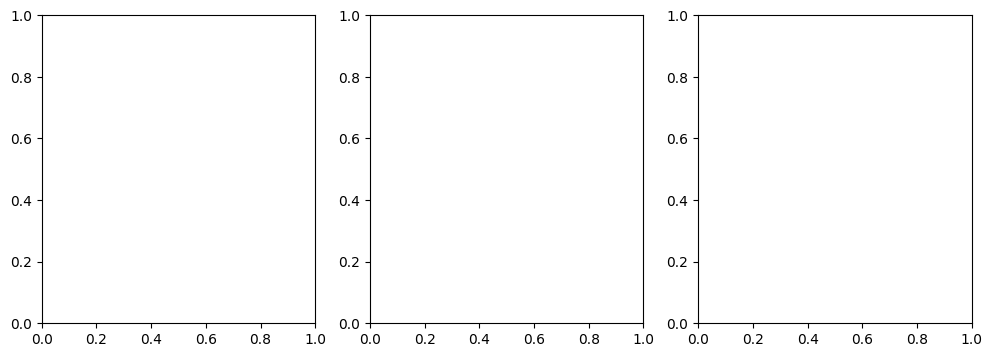

In [147]:
f, axs = plt.subplots(1, 3, figsize = (12,4))

xs = jnp.linspace(-5, 5, num = 1000)
ys = jnp.linspace(-5, 5, num = 1000)
xss, yss = jnp.meshgrid(xs, ys)
im = jnp.stack((xss, yss, jnp.ones_like(xss) * 0), axis = 2)

res = ansatz.calc_psi(param, im.reshape(-1, 3)).reshape(xss.shape)
res = res.real


axs[0].imshow(res, extent = [-5, 5, -5, 5])
axs[0].set_title("Ansatz")

res = ansatz.eval_nn(param, im.reshape(-1, 3)).reshape(xss.shape)
axs[1].imshow(jnp.exp(res), extent = [-5, 5, -5, 5])
axs[1].set_title("Neural Network")


r, line = getLine(0, jnp.pi/2, r_max=10)
psi = ansatz.calc_psi(param, line)
nn_out = ansatz.eval_nn(param, line)

axs[2].plot(r, psi, label = "Ansatz")
axs[2].plot(r, nn_out, label = "NN output")
# axs[2].set_yscale("log")
axs[2].set_title("Psi")
axs[2].legend()
axs[2].set_xlabel("x")

f.tight_layout()

## Sampler

In [148]:
class SymmetrySampler(module.samplers.MCMC):
    def propose(self, key, element):
        subkey, _ = jax.random.split(key)

        mirrorprob = 0.01

        var = jax.random.normal(key, shape = self.shape) * jnp.sqrt(self.variance)
        inv = -element

        decide = jax.random.uniform(key)

        proposal = jnp.where(decide < mirrorprob, inv, element + var)

        return subkey, proposal
sampler = SymmetrySampler(ansatz, 0.5)
subsampling = 10
def get_samples(N):
    """
    Returns decorrelated samples.
    """
    samples, ratio = sampler.sample(key, param, jax.random.normal(key, shape = (6,)), N*subsampling)
    return samples[0:-1:subsampling], ratio

## Optimisation

In [149]:
@partial(jax.jit, static_argnames=['hamiltonian', 'orbital'])
def calc_grad_E(hamiltonian, orbital, parameters, samples):
    """
    Calculates the gradient of the energy and the energy itself on a batch of samples.
    """

    E_loc = hamiltonian.calc_H_loc(orbital, parameters, samples)
    E = jnp.mean(E_loc)
    dE = jnp.std(E_loc)

    logpsi_red = lambda parameters: orbital.calc_logpsi(parameters, samples)
    y, v = jax.vjp(logpsi_red, parameters)
    N = samples.shape[0]

    m = lambda tree: 2*jnp.real(tree/N)

    return jax.tree_util.tree_map(m, v(E_loc - E))[0], E, dE
def eval_S1(orbital, parameters, samples, v):
    f = lambda param: orbital.calc_logpsi(param, samples)
    N = samples.shape[0]

    a = jax.jvp(f, (parameters,), (v,))[1]
    b = netket.jax.vjp(f, parameters)[1](a)[0]
    return jax.tree_util.tree_map(lambda x: 1/N*x, b)

def eval_S2(orbital, parameters, samples, v):
    f = lambda param: orbital.calc_logpsi(param, samples)
    N = samples.shape[0]
    e = jnp.ones(N)

    a = jnp.sum(jax.jvp(f, (parameters,), (v,))[1])
    b = jax.vjp(f, parameters)[1](e)[0]
    return  jax.tree_util.tree_map(lambda v: 1/N**2 * a * v, b)

@partial(jax.jit, static_argnames=['orbital'])
def eval_S(orbital, parameters, samples, v):
    s1 = eval_S1(orbital, parameters, samples, v)
    s2 = eval_S2(orbital, parameters, samples, v)
    return jax.tree_util.tree_map(lambda a,b: a-b, s1, s2)
eps = 1e-4

def reg_S(ansatz, param, samples, v):
    u = eval_S(ansatz, param, samples, v)
    return jax.tree_util.tree_map(lambda a,b: a + eps * b, u, v)

@jax.jit
def calc_natural_grad(param, samples):
    A = lambda v: reg_S(ansatz, param, samples, v)
    b, E, dE = calc_grad_E(hamiltonian, ansatz, param, samples)
    return jax.scipy.sparse.linalg.cg(A, b)[0], E, dE

In [150]:
stats = {"E":[], "dE":[], "ratio":[], "N_samples": []}
param = ansatz.init_param(key)

In [154]:
N = 800
epoch = 500

# define
optimizer = optax.sgd(learning_rate=0.01)

# initialise
optimizer_state = optimizer.init(param)

In [157]:
for i in tqdm(range(epoch)):
    key, _ = jax.random.split(key)
    samples, ratio = get_samples(N)
    grad, E, dE = calc_natural_grad(param, samples)

    stats["E"].append(E)
    stats["dE"].append(dE)
    stats["ratio"].append(ratio)
    stats["N_samples"].append(N)
    
    updates, optimizer_state = optimizer.update(grad, optimizer_state, param)

    param = optax.apply_updates(param, updates)

100%|██████████| 500/500 [00:04<00:00, 111.43it/s]


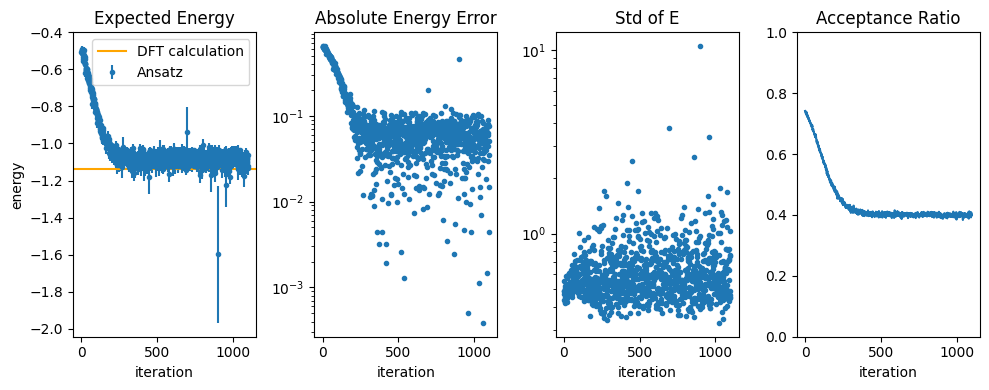

In [164]:
numpy_stats = {}
for key_ in stats.keys():
    numpy_stats[key_] = np.array(stats[key_])

f, ax = plt.subplots(1, 4, figsize = (10, 4))
i = np.arange(len(stats["E"]))

ax[0].errorbar(i, numpy_stats["E"], yerr = numpy_stats["dE"]/jnp.sqrt(numpy_stats["N_samples"]), fmt = ".", label = "Ansatz")
# ax[0].fill_between(i, numpy_stats["E"] - numpy_stats["dE"], numpy_stats["E"] + numpy_stats["dE"], alpha = 0.5)
ax[0].set_title("Expected Energy")
ax[0].axhline(E_f, label = "DFT calculation", color = "orange")
ax[0].legend(loc = "upper right")
# ax[0].set_ylim(-0.63, -0.33)
# ax[0].set_ylim(-0.8, -1.3)
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("energy")

ax[1].scatter(i, jnp.abs(numpy_stats["E"]-E_f) , label = "error", marker = ".")
ax[1].set_title("Absolute Energy Error")
ax[1].set_yscale("log")
ax[1].set_xlabel("iteration")

ax[2].scatter(i, stats["dE"], marker = ".")
ax[2].set_title("Std of E")
ax[2].set_yscale("log")
ax[2].set_xlabel("iteration")

ax[3].plot(stats["ratio"])
ax[3].set_ylim(0,1)
ax[3].set_title("Acceptance Ratio")
ax[3].set_xlabel("iteration")

f.tight_layout()

n_param = sum(x.size for x in jax.tree_util.tree_leaves(param))


## Energy Inspection

In [163]:
N = 10000
key, _ = jax.random.split(key)
samples, ratio = get_samples(N)
H_loc = hamiltonian.calc_H_loc(ansatz, param, samples)
print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc),"+/-", jnp.std(H_loc)/jnp.sqrt(N))
print("Energy Error:", (jnp.mean(H_loc) - E_f)/jnp.abs(E_f))
print("Std of Expected Energy:", jnp.std(H_loc))

Acceptance Ratio: 0.40255
Expected Energy: -1.0966577491987708 +/- 0.009701834942566673
Energy Error: 0.03503387372709492
Std of Expected Energy: 0.9701834942566673
